# Paul Adams
# DS 7337 Natural Language Processing
# HW 8: Universal Sentence Encoder
# 6 August 2020

Homework 8.
Utilize the Universal Sentence encoder to build a model for the following dataset.  Note--we want to POLARITY not Sentiment column, although the data is setup correctly already



In [1]:
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re

In [2]:
print("Tensorflow Version:\n{}\n\nTensor-Hub Version:\n{}".format(tf.__version__, hub.__version__))

Tensorflow Version:
2.1.0

Tensor-Hub Version:
0.8.0


In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [5]:
use_test = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

In [7]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,Alright normally i am not as harsh on sequels ...,1,0
1,In a summer that also boasted such repugnant s...,1,0
2,"well ""Wayne's World"" is long gone and the year...",7,1
3,Neil Simon had a knack for dialog and nowhere ...,7,1
4,"John Water's (""Pink Flamingos""...) ""Pecker"" is...",10,1


In [123]:
# Create datasets (Only take up to 150 words for memory)
X_train = train_df['sentence'].tolist()
X_train = [' '.join(t.split()[0:150]) for t in X_train]
X_train = np.array(X_train, dtype=object)[:, np.newaxis]
y_train = train_df['polarity']

X_test = test_df['sentence'].tolist()
X_test = [' '.join(t.split()[0:150]) for t in X_test]
X_test = np.array(X_test, dtype=object)[:, np.newaxis]
y_test = test_df['polarity']

In [124]:
labels = pd.concat([y_train, y_test], axis=0)
labels.shape

(50000,)

In [125]:
use_test(X_train[1])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.04367509, -0.01291919,  0.03765082,  0.01142884,  0.01711245,
         0.03624368,  0.04683387, -0.008366  ,  0.04108839, -0.02592995,
         0.05034969, -0.00684038,  0.04716497,  0.02605234,  0.0360189 ,
        -0.01083197,  0.02326423,  0.01398808,  0.04514677,  0.03130375,
         0.0485029 , -0.08242615, -0.06579089,  0.00807688,  0.01847394,
        -0.02332816, -0.01662179, -0.06268647,  0.01870472,  0.08181003,
         0.00425646, -0.02950539,  0.06359997,  0.06583823, -0.00215857,
         0.04725979, -0.05938808,  0.00674259, -0.0123295 ,  0.00585958,
         0.05666545,  0.01338516, -0.07623735, -0.0420394 ,  0.03205598,
        -0.04789669, -0.01408493, -0.00505174,  0.02215784,  0.05671274,
         0.0702633 , -0.05932406, -0.00923373,  0.00829978, -0.02720018,
        -0.02813815, -0.03887885, -0.0121702 ,  0.03268609, -0.05418092,
         0.08224507, -0.03254161, -0.06474393, -0.02242578, -0.06911825,
 

In [11]:
print("Train Data Length: {}\nValidation Data Length:{}".format(X_train.shape[0], X_test.shape[0]))

Train Data Length: 25000
Validation Data Length:25000


In [146]:
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten,
                                     MaxPooling2D, Conv2D, Lambda,
                                     Concatenate)

def UniversalEmbedding(x):
    return use_test(tf.squeeze(tf.cast(x, tf.string)))

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None,)]                 0         
_________________________________________________________________
keras_layer_24 (KerasLayer)  (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
output (Dense)               (None, 2)                 514       
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


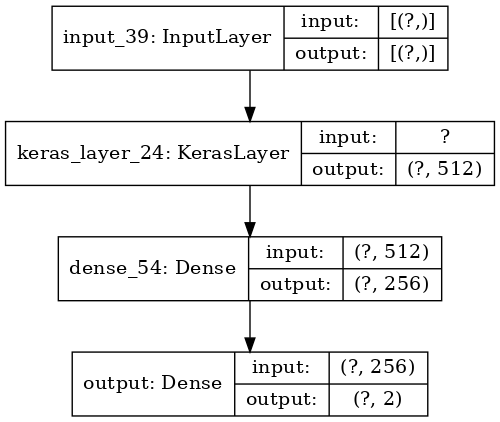

In [131]:
embed_size = 512 # since USE produces 512 vector lengths regardless of input size

input_text = Input(shape=(), dtype=tf.string)

embedding = hub.KerasLayer(UniversalEmbedding, output_shape=(embed_size,))(input_text)

x = Dense(256, activation='relu')(embedding)
output = Dense((1),activation='sigmoid',name='output')(x) # sigmoid for 2-classes

model = Model(inputs=input_text, outputs=[output])

model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [112]:
hist = model.fit(X_train, y_train,
                 batch_size = 10,
                 epochs = 5,
                 validation_data=(X_test, y_test))

Epoch 1/5
2500/2500 [==============================] - 44s 18ms/step - loss: 0.4051 - accuracy: 0.8221 - val_loss: 0.3294 - val_accuracy: 0.8543
Epoch 2/5
2500/2500 [==============================] - 50s 20ms/step - loss: 0.3333 - accuracy: 0.8571 - val_loss: 0.3276 - val_accuracy: 0.8537
Epoch 3/5
2500/2500 [==============================] - 48s 19ms/step - loss: 0.3132 - accuracy: 0.8677 - val_loss: 0.3211 - val_accuracy: 0.8612
Epoch 4/5
2500/2500 [==============================] - 49s 20ms/step - loss: 0.3084 - accuracy: 0.8714 - val_loss: 0.3291 - val_accuracy: 0.8608
Epoch 5/5
2500/2500 [==============================] - 48s 19ms/step - loss: 0.2852 - accuracy: 0.8834 - val_loss: 0.3326 - val_accuracy: 0.8561


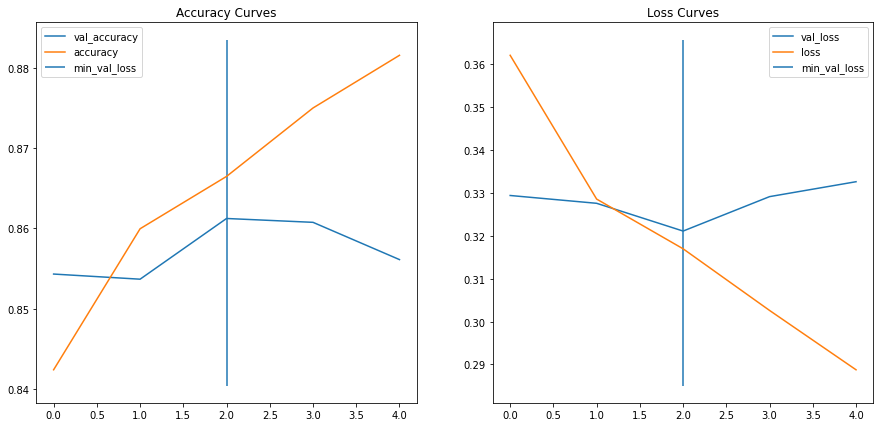

In [113]:
import matplotlib.pyplot as plt

val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend();

ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

In [58]:
hist = model.fit(X_train, y_train,
                 batch_size = 20,
                 epochs = 5,
                 validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 [==============================] - 38s 30ms/step - loss: 0.3956 - accuracy: 0.8236 - val_loss: 0.3470 - val_accuracy: 0.8482
Epoch 2/5
1250/1250 [==============================] - 37s 29ms/step - loss: 0.3167 - accuracy: 0.8637 - val_loss: 0.3187 - val_accuracy: 0.8601
Epoch 3/5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.2926 - accuracy: 0.8784 - val_loss: 0.3355 - val_accuracy: 0.8579
Epoch 4/5
1250/1250 [==============================] - 37s 29ms/step - loss: 0.2634 - accuracy: 0.8940 - val_loss: 0.3423 - val_accuracy: 0.8539
Epoch 5/5
1250/1250 [==============================] - 36s 28ms/step - loss: 0.2295 - accuracy: 0.9080 - val_loss: 0.3550 - val_accuracy: 0.8501


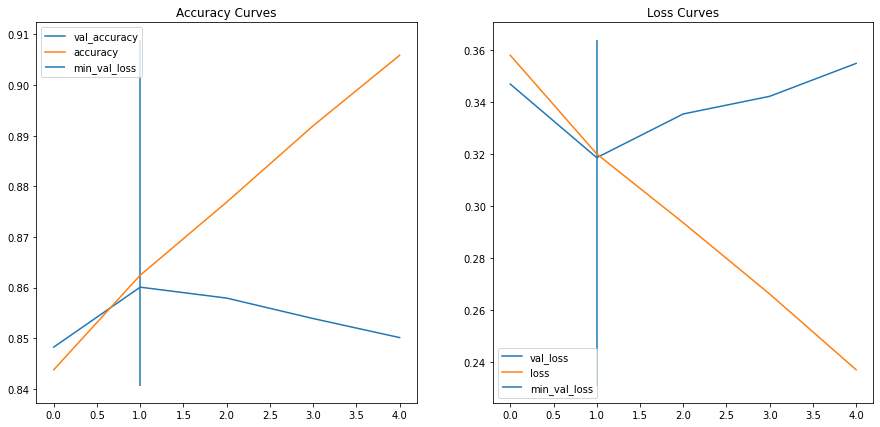

In [63]:
val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend();

ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

In [68]:
hist = model.fit(X_train, y_train,
                 batch_size = 20,
                 epochs = 5,
                 validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.4127 - accuracy: 0.8133 - val_loss: 0.3282 - val_accuracy: 0.8539
Epoch 2/5
1250/1250 [==============================] - 34s 27ms/step - loss: 0.3316 - accuracy: 0.8584 - val_loss: 0.3330 - val_accuracy: 0.8578
Epoch 3/5
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3137 - accuracy: 0.8691 - val_loss: 0.3230 - val_accuracy: 0.8577
Epoch 4/5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.2957 - accuracy: 0.8778 - val_loss: 0.3283 - val_accuracy: 0.8588
Epoch 5/5
1250/1250 [==============================] - 34s 28ms/step - loss: 0.2844 - accuracy: 0.8832 - val_loss: 0.3377 - val_accuracy: 0.8549


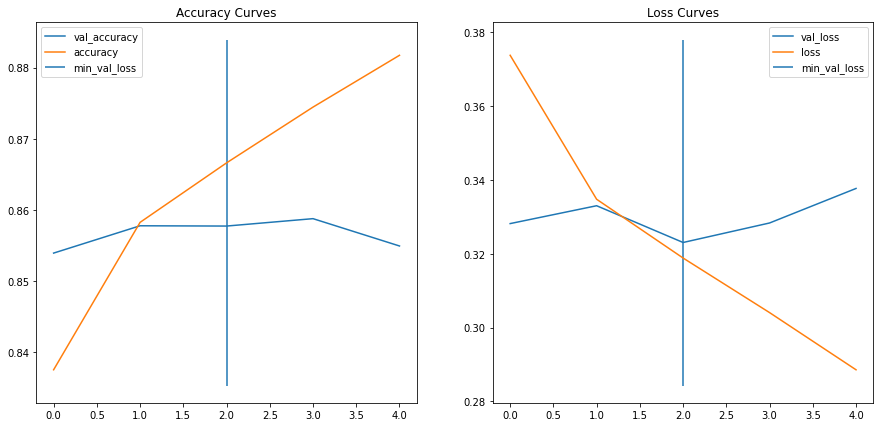

In [69]:
val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend();

ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

In [71]:
hist = model.fit(X_train, y_train,
                 batch_size = 20,
                 epochs = 5,
                 validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 [==============================] - 37s 29ms/step - loss: 0.4157 - accuracy: 0.8131 - val_loss: 0.3345 - val_accuracy: 0.8537
Epoch 2/5
1250/1250 [==============================] - 33s 26ms/step - loss: 0.3327 - accuracy: 0.8608 - val_loss: 0.3342 - val_accuracy: 0.8556
Epoch 3/5
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3210 - accuracy: 0.8643 - val_loss: 0.3288 - val_accuracy: 0.8563
Epoch 4/5
1250/1250 [==============================] - 36s 28ms/step - loss: 0.3028 - accuracy: 0.8741 - val_loss: 0.3211 - val_accuracy: 0.8602
Epoch 5/5
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2849 - accuracy: 0.8852 - val_loss: 0.3452 - val_accuracy: 0.8568


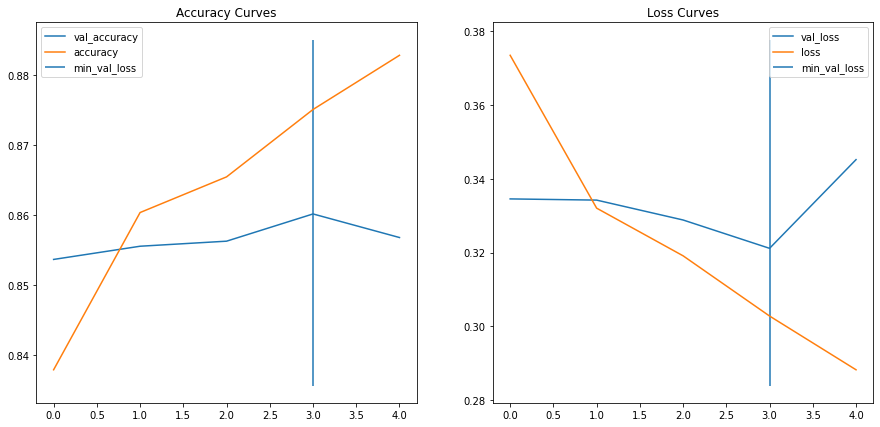

In [72]:
val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend();

ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

In [74]:
hist = model.fit(X_train, y_train,
                 batch_size = 20,
                 epochs = 5,
                 validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 [==============================] - 34s 28ms/step - loss: 0.4034 - accuracy: 0.8182 - val_loss: 0.3275 - val_accuracy: 0.8578
Epoch 2/5
1250/1250 [==============================] - 33s 26ms/step - loss: 0.3291 - accuracy: 0.8571 - val_loss: 0.3229 - val_accuracy: 0.8578
Epoch 3/5
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3055 - accuracy: 0.8736 - val_loss: 0.3295 - val_accuracy: 0.8558
Epoch 4/5
1250/1250 [==============================] - 35s 28ms/step - loss: 0.2853 - accuracy: 0.8821 - val_loss: 0.3452 - val_accuracy: 0.8585
Epoch 5/5
1250/1250 [==============================] - 33s 26ms/step - loss: 0.2639 - accuracy: 0.8925 - val_loss: 0.3351 - val_accuracy: 0.8581


In [80]:
str("😂")

'😂'

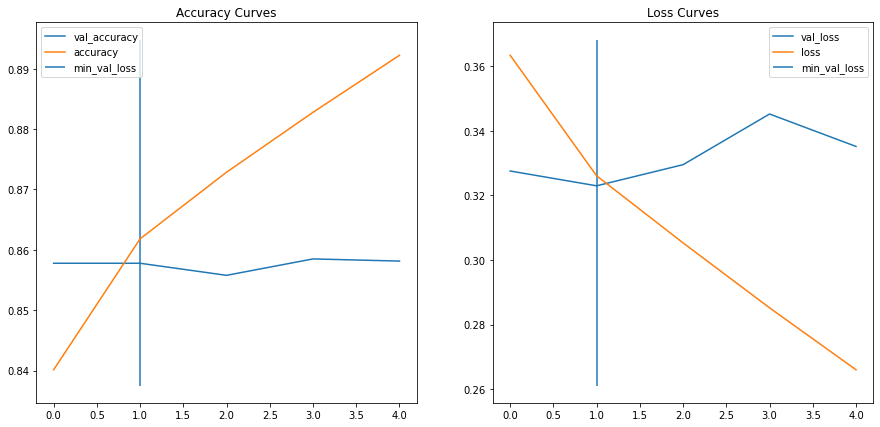

In [75]:
val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend();

ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

In [77]:
hist = model.fit(X_train, y_train,
                 batch_size = 20,
                 epochs = 5,
                 validation_data=(X_test, y_test))

Epoch 1/5
1250/1250 [==============================] - 35s 28ms/step - loss: 0.4651 - accuracy: 0.7783 - val_loss: 0.3274 - val_accuracy: 0.8560
Epoch 2/5
1250/1250 [==============================] - 34s 27ms/step - loss: 0.3549 - accuracy: 0.8514 - val_loss: 0.3223 - val_accuracy: 0.8596
Epoch 3/5
1250/1250 [==============================] - 32s 26ms/step - loss: 0.3379 - accuracy: 0.8556 - val_loss: 0.3221 - val_accuracy: 0.8577
Epoch 4/5
1250/1250 [==============================] - 36s 28ms/step - loss: 0.3252 - accuracy: 0.8657 - val_loss: 0.3282 - val_accuracy: 0.8552
Epoch 5/5
1250/1250 [==============================] - 39s 31ms/step - loss: 0.3139 - accuracy: 0.8704 - val_loss: 0.3402 - val_accuracy: 0.8497


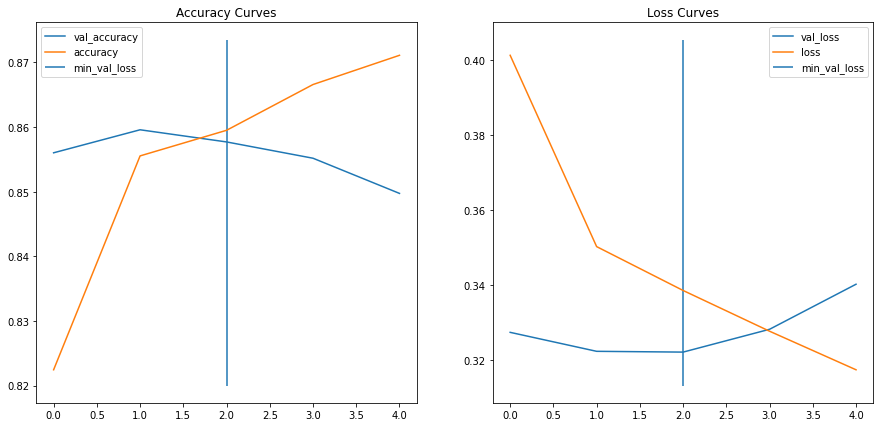

In [78]:
val_loss = hist.history['val_loss']
min_loss_loc = np.where(val_loss==np.min(val_loss))[0][0]

fig, ax = plt.subplots(ncols=2, figsize = (15,7))
ax[0].plot(hist.history['val_accuracy'], label = 'val_accuracy')
ax[0].plot(hist.history['accuracy'], label = 'accuracy')
ax[0].vlines(min_loss_loc, *ax[0].get_ylim(), label = 'min_val_loss')
ax[0].set_title('Accuracy Curves')
ax[0].legend();

ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].plot(hist.history['loss'], label = 'loss')
ax[1].vlines(min_loss_loc, *ax[1].get_ylim(), label = 'min_val_loss')
ax[1].set_title('Loss Curves')
ax[1].legend();

In [ ]:
data=np.zeros([2500,150,1024])
step=0

for i in range(100):
    index = i*10
    stop = index+10
    tmp = X_train[index:index+10]
    x = tf.convert_to_tensor(tmp)
    out = elmo.signatures['default'](tf.squeeze(x))
    data[index:stop,] = out['elmo']
    
    print(i)

In [93]:
#elmo = hub.load("https://tfhub.dev/google/elmo/2")
elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3",trainable=False)

In [94]:
elmo(tf.convert_to_tensor(["the cat is on the mat", "dogs are in the fog"]))

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.05517213, -0.02187638, -0.17496817, ..., -0.36848047,
         0.09267832,  0.23179083],
       [-0.00230274,  0.15438525, -0.24050388, ..., -0.10671462,
         0.08977063,  0.24189015]], dtype=float32)>

In [ ]:
# just a random sentence
x = ["Roasted ants are a popular snack in Columbia"]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

embeddings.shape

In [ ]:
def elmo_vectors(x):
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))